# Q-Learning-Based Trading Environment — Developed a custom trading environment and trained a tabular Q-learning agent to maximize profit on historical market data :


# Requirements:


In [1]:
# pip install ta finpy_tse yfinance

In [2]:
import finpy_tse as fpy  # library for getting daily price
# import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import ta   # technical indicators
import pandas as pd
import random
import itertools # for creating all combinations - cartesian product

# Getting Historical Data:

In [3]:
df = fpy.Get_Price_History(
                    stock='وبملت',
                    start_date='1397-01-01',
                    end_date='1404-04-20',
                    ignore_date=False,
                    adjust_price=True,
                    show_weekday=True,
                    double_date=False)

# df = yf.download("TSLA", start="2018-01-01", end="2024-12-31", auto_adjust=False)
df.shape

# df = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
# # Use Adjusted Close for RSI
# df["RSI"] = ta.momentum.RSIIndicator(close=df["Adj Close"]).rsi()

C:\Users\msi\anaconda3\envs\RL_Agent2\lib\site-packages\finpy_tse\__init__.py:424: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_history = pd.concat([df_history,df_temp])


(1538, 17)

In [4]:
df.head() #testing

,Weekday,Open,High,Low,Close,Final,Volume,Value,No,Ticker,Name,Market,Adj Open,Adj High,Adj Low,Adj Close,Adj Final
J-Date,,,,,,,,,,,,,,,,,
1397-01-05,Sunday,974,1010,974,1010,1003,636573,634163677,69,وبملت,بانک ملت,بورس,18,18,18,18,18
1397-01-06,Monday,1007,1007,977,1002,1000,5040802,5029024639,229,وبملت,بانک ملت,بورس,18,18,18,18,18
1397-01-07,Tuesday,978,1000,978,999,999,2090814,2079501927,113,وبملت,بانک ملت,بورس,18,18,18,18,18
1397-01-08,Wednesday,983,1000,969,1000,994,3491187,3437408015,253,وبملت,بانک ملت,بورس,18,18,18,18,18
1397-01-14,Tuesday,974,998,974,996,994,1354399,1343896569,68,وبملت,بانک ملت,بورس,18,18,18,18,18


### In the following code snippet, we first select the key columns from the dataset and then use the adjusted closing price to compute both the simple return and the percentage return.﻿

### The adjusted closing price is the closing price that has been corrected for corporate actions such as capital increases and cash dividend payments, allowing for a more accurate analysis of the stock’s trend and total return, since the share price typically falls when dividends are paid.﻿

### Finally, we compute the RSI indicator using the ta library.

In [5]:
df = df[['Adj Close','Volume','Close']]
df["return"] = df["Adj Close"].diff()
df["percentage return"] = df["Adj Close"].pct_change()
df['rsi'] = ta.momentum.rsi(df['Adj Close'], window=14, fillna=False) # window=14 means we use 14 previous days to calculate RSI
# df['rsi'] = RSIIndicator(close=df["Adj Close"].squeeze(), window=14).rsi()

# source: https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.momentum.RSIIndicator

# (Relative Strength Index)RSI Formula:


$$
RSI_{\text{step one}} = 100 - \left[ \frac{100}{1 + \frac{\text{Average gain}}{\text{Average loss}}} \right]
$$

Note: As you can see in the table below, computing this indicator requires data from the previous 14 days, so the first 13 rows of the table will contain NaN values. If the value of this indicator is greater than 70, it means the asset is overbought and demand has been elevated for some time; the price has already increased significantly, which we interpret as a sell signal. Conversely, if the value of this indicator is less than 30, it means the asset is oversold and there has been heavy selling pressure; the price has declined sufficiently, which we interpret as a buy signal. When the indicator lies between 30 and 70, we do not take any action (Hold).

[Source : https://www.investopedia.com/terms/r/rsi.asp ](https://www.investopedia.com/terms/r/rsi.asp)

In [6]:
df.iloc[:14,:]

,Adj Close,Volume,Close,return,percentage return,rsi
J-Date,,,,,,
1397-01-05,18,636573,1010,NaN,NaN,NaN
1397-01-06,18,5040802,1002,0.0,0.000000,NaN
1397-01-07,18,2090814,999,0.0,0.000000,NaN
1397-01-08,18,3491187,1000,0.0,0.000000,NaN
1397-01-14,18,1354399,996,0.0,0.000000,NaN
1397-01-15,18,4522617,992,0.0,0.000000,NaN
1397-01-18,18,1633395,985,0.0,0.000000,NaN
1397-01-19,18,2857786,970,0.0,0.000000,NaN
1397-01-20,18,9854861,960,0.0,0.000000,NaN


<hr style="height:3px;color:red;background-color:red">

# Discretization:



### Next, we discretize the continuous variables—trading volume, return, and RSI—into a finite number of bins. We define the discretization scheme for the stock return as follows:

\begin{cases}
\text{Down} & \text{if } \: \text{return} \leq -1\% \\
\text{Flat} & \text{if } \: -1\% < \text{return} \leq 1\% \\
\text{Up} & \text{if } \: \text{return} > 1\%
\end{cases}


In [7]:
df['returns_binned'] = pd.cut( df["return"], [-np.inf, -0.01, 0.01, np.inf], labels=["Down", "Flat", "Up"] , right=True)

In [8]:
df.returns_binned.value_counts().sort_index() #testing

returns_binned
Down    651
Flat    191
Up      695
Name: count, dtype: int64

<hr style="height:3px;color:red;background-color:red">

### We define the discretization of the RSI indicator as follows:﻿

\begin{cases}
0 \leq \text{RSI} \leq 30 & \text{Oversold} \\
30 < \text{RSI} \leq 70 & \text{Neutral} \\
70 < \text{RSI} \leq 100 & \text{Overbought}
\end{cases}

In [9]:
df['rsi_binned'] = pd.cut( df["rsi"], [-np.inf, 30, 70, np.inf], labels=["Oversold", "Neutral", "Overbought"] )

In [10]:
df.rsi_binned.value_counts().sort_index()  #testing

rsi_binned
Oversold        62
Neutral       1250
Overbought     213
Name: count, dtype: int64

<hr style="height:3px;color:red;background-color:red">

### We define the discretization of trading volume as follows:

\begin{cases}
\text{low}, & Volume < 50,000,000 \\
\text{medium}, & 50,000,000 \leq Volume < 150,000,000 \\
\text{high}, & Volume \geq 150,000,000
\end{cases}

In [11]:
def volume_level(v):
    if v < 50000000:
        return "low"
    elif v < 150000000:
        return 'medium'
    else:
        return "high"

df['Volume_binned'] = df['Volume'].apply(volume_level)

In [12]:
df.Volume_binned.value_counts().sort_index()

Volume_binned
high      842
low       164
medium    532
Name: count, dtype: int64

<hr style="height:3px;color:red;background-color:red">

### The following command removes all rows that contain NaN values. Therefore, we expect the first 14 rows to be dropped.

In [13]:
df = df.dropna()

In [14]:
df.tail()

,Adj Close,Volume,Close,return,percentage return,rsi,returns_binned,rsi_binned,Volume_binned
J-Date,,,,,,,,,
1404-04-10,1077,8019683056,2199,-34.0,-0.030603,27.543358,Down,Oversold,high
1404-04-11,1109,3095602328,2264,32.0,0.029712,33.491510,Up,Neutral,high
1404-04-16,1128,2336129457,2303,19.0,0.017133,36.808548,Up,Neutral,high
1404-04-17,1094,1060230007,2232,-34.0,-0.030142,33.580971,Down,Neutral,high
1404-04-18,1100,1184103135,2246,6.0,0.005484,34.669650,Up,Neutral,high


<hr style="height:3px;color:red;background-color:red">

### In the following code snippet, we split the dataset into training and test sets.﻿

In [15]:
n = len(df)
test_size = int(n*0.2)
train = df.iloc[:n - test_size]
test = df.iloc[n - test_size:]
print(train.shape)
print(test.shape)

# #Split data into test and train
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(df, test_size = 0.2, random_state = 421)
# print(train.shape)
# print(test.shape)

(1220, 9)
(305, 9)


<hr style="height:3px;color:red;background-color:red">

### In this section, we define the Agent class, which takes the number of actions and states, along with the hyperparameters and a seed (for reproducibility and hyperparameter tuning), as input.

<div justify-content: center; >
<img src="https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png" alt="Girl in a jacket" width="800" height="900">
</div>

### In this section, we implement epsilon-greedy action selection along with the Q-learning update rule.



In [16]:
class Agent:
    def __init__(self,agent_info):
        self.num_actions = agent_info["num_actions"]
        self.num_states = agent_info["num_states"]
        self.epsilon = agent_info["epsilon"] #hyper parameter
        self.epsilon_decay = 0.975
        self.epsilon_min = 0.001
        self.step_size = agent_info["step_size"] #hyper parameter
        self.discount = agent_info["discount"] #hyper parameter
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        # self.Q = np.zeros((self.num_states, self.num_actions))       
        returns = ["Down", "Flat", "Up"]
        rsi = ["Oversold", "Neutral", "Overbought"]
        volume = ['low','medium','high']
        states = list(itertools.product(returns, rsi, volume)) # gives all cominations - cartesian product
        actions = [-1, 0, 1]   # Short - Hold - Long
        self.Q = pd.DataFrame(0,index=pd.MultiIndex.from_tuples(states, names=['Return_binned', 'RSI_binned', 'Volume_binned']), columns=actions)

    # Epsilon-greedy Action selection
    def getAction(self,state):
        if self.rand_generator.rand() < self.epsilon:
            return self.rand_generator.choice([-1,0,1])
        else:
            # print(self.Q.loc[state])
            # print(self.Q.loc[state].idxmax())
            # return np.argmax(self.Q.loc[state]) 
            return self.Q.loc[state].idxmax()
         
    # Q-learning Update
    def update(self,state,action,reward,next_state):
            self.Q.loc[state,action]= self.Q.loc[state,action] + (self.step_size * (reward + (self.discount * np.max(self.Q.loc[next_state, :]))
                                                                - self.Q.loc[state,action]))


<hr style="height:3px;color:red;background-color:red">

# State and Reward Definition : 


### The environment states are represented as tuples with three components, defined as follows:

$$\mathcal{S} = \left\{ (r, rsi , v) \mid r \in \text{return binned},\; rsi \in \text{RSI binned},\; v \in \text{volume binned} \right\}
$$

### In fact, the action only influences our reward. For example, if we took a long position on the first day and prices increase on the second day, we make a profit; conversely, if prices decrease on the second day, we incur a loss.


In [17]:
def get_state(row):
    return (row['returns_binned'],
            row['rsi_binned'],
            row['Volume_binned']
            )

<h4 dir="rtl" style="text-align: right;">
    
### The reward is computed as follows: the index of the position taken on the previous day multiplied by the return from yesterday to today, minus the trading cost.

$$r_t = \text{position}_t \times \text{return}_t - \text{trading cost}$$

<div justify-content: center >
<p dir="rtl" style="text-align: left;">
<img src="https://centerpointsecurities.com/wp-content/uploads/2022/12/How-Short-Selling-Works-1024x830.png" alt="Girl in a jacket" width="300" height="400" style="margin-left:15px;float: right " >
    
Overview of the short (short-selling) position:
<br>
When we expect the stock price to fall, we borrow someone else’s shares and sell them on the market, for example at $400.
After some time, when the price drops to 200, we buy back the same shares at 200 and return them to the original owner, making a profit of 200. However, if our prediction is wrong and the share price rises to 600, we will incur a loss, because we must repurchase the shares at the higher price and return them to the owner.
<br>
According to the above formula, for the two cases we obtain the following, respectively:
</p>
</div>

$$ r = (-1) \times (-200) - \text{trading cost} > 0 $$
$$ r = (-1) \times (200) - \text{trading cost} < 0 $$

<br>
<br>
<hr>
<br>
<div justify-content: center >
<p dir="rtl" style="text-align: left;">
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ-l2HLEQcQRFcC--cbCBr9r4N66nJiRQBJFt9SeYeVnkpCfplQioRetMplEOU8M8YzBOI&usqp=CAU" alt="Girl in a jacket" width="300" height="400" style="margin-left:15px;float: right " >
    
Overview of the long (buy) position:
<br>
When we expect the stock price to rise, we buy a share at, for example, 400. After some time, when the price increases to 600, we sell the share and make a profit of 200; however, if our prediction is wrong and the price falls to $200, we incur a loss.
<br>
According to the above formula, for the two cases we obtain the following, respectively:
</p>
</div>

$$ r = (1) \times (200) - \text{trading cost} > 0 $$
$$ r = (1) \times (-200) - \text{trading cost} < 0 $$

In [18]:
def getReward(index,last_position,TradingCost):
    # print(df.iloc[index+1,8])
    # print(last_position)
    return (train.iloc[index+1,3] * last_position) - TradingCost # (return amount * last postion ) - trading cost

<hr style="height:3px;color:red;background-color:red">

### In the following section, we create an instance of the Agent class and pass the initial values as a dictionary.

In [19]:
# np.random.seed(42)

# num_states = num_rsi * num_volume * num_returns
num_states = 3 * 3 * 3

agent_info = {"num_actions": 3, "num_states": num_states, "epsilon": 1, "step_size": 0.06, "discount": 0.618, "seed": 0}
agent = Agent(agent_info)

<hr style="height:3px;color:red;background-color:red">

### As you will see, the tabular Q-learning table, in which each row corresponds to a three-component state, is initialized with zeros.﻿

In [20]:
# agent.Q.loc[('Flat', 'Overbought', 'low'), 0]  # How to Access values of table
agent.Q

-1   0   1
Return_binned RSI_binned Volume_binned            
Down          Oversold   low             0   0   0
                         medium          0   0   0
                         high            0   0   0
              Neutral    low             0   0   0
                         medium          0   0   0
                         high            0   0   0
              Overbought low             0   0   0
                         medium          0   0   0
                         high            0   0   0
Flat          Oversold   low             0   0   0
                         medium          0   0   0
                         high            0   0   0
              Neutral    low             0   0   0
                         medium          0   0   0
                         high            0   0   0
              Overbought low             0   0   0
                         medium          0   0   0
                         high            0   0   0
Up            Oversold   low             0   0   0
                         medium          0   0   0
                         high            0   0   0
              Neutral    low             0   0   0
                         medium          0   0   0
                         high            0   0   0
              Overbought low             0   0   0
                         medium          0   0   0
                         high            0   0   0

<hr style="height:3px;color:red;background-color:red">

# Training:
## In the following section, we run the Q-learning loop on the training data and add auxiliary variables for generating analytical plots.﻿

In [21]:
episode_num= 300
cumulative_returns = []
navs = [] # for nav evolution
profits = [] # for buy and hold
win_loss = [] # win/loss ratio
long_num = [] 
hold_num = [] 
short_num = [] 
for episode in range(episode_num):
    state = get_state(train.iloc[0,:])
    # print(state)
    last_position = 0 # first position is hold
    cumulative_return = 0 
    profit = 0
    termination = False
    index = 0
    nav = 2000 # equvalent to 1 dollar
    actions_num = [0,0,0] # short - hold - long
    win = 0
    loss = 0
    reward_of_current_trade = 0 # for win-loss measure
    while termination == False and index < train.shape[0]-1:
        action = agent.getAction(state)

        if action == 1 :
            actions_num[2] += 1
        elif action == 0:
            actions_num[1] += 1
        else :
            actions_num[0] += 1
            
        # print(action)
        TradingCost =0
        # print(index)
        # print(action)
        if action != 0:
            if last_position != action: # avoids getting long postion again instead just hold it
                last_position = action
                TradingCost = train.iloc[index,0] * 0.001  # 0.1 percent of the trade value.

                if reward_of_current_trade > 0:
                    win +=1
                else:
                    loss +=1
                reward_of_current_trade = 0 # when we trade again we set it to zero
                
        # using rsi for choosing action       
        # if action == 0 :
        #     if state[1] == "Oversold":
        #         last_position = 1
        #         TradingCost = df.iloc[index,0] * 0.001
        #     if state[1] == "Overbought":
        #         last_position = -1
        #         TradingCost = df.iloc[index,0] * 0.001

        # print(last_position)
        reward = getReward(index,last_position,TradingCost)
        reward_of_current_trade += reward
        nav += reward
        profit += train.iloc[index+1,3] 
        cumulative_return += reward
        if nav <= 0 :
            termination = True
        next_state = get_state(train.iloc[index+1,:])
        agent.update(state,action,reward,next_state)
        state = next_state
        index +=1
    if nav < 0 :
        print(index)   
    cumulative_returns.append(cumulative_return)
    navs.append(nav)
    profits.append(profit)
    if loss != 0:
        win_loss.append(win/loss)
    long_num.append(actions_num[2])
    hold_num.append(actions_num[1])
    short_num.append(actions_num[0])
    if (agent.epsilon > agent.epsilon_min) and episode>1:
                    agent.epsilon *= agent.epsilon_decay
    # print(agent.epsilon)

C:\Users\msi\AppData\Local\Temp\ipykernel_29532\2800724453.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.00102' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.Q.loc[state,action]= self.Q.loc[state,action] + (self.step_size * (reward + (self.discount * np.max(self.Q.loc[next_state, :]))
C:\Users\msi\AppData\Local\Temp\ipykernel_29532\2800724453.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.00102' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.Q.loc[state,action]= self.Q.loc[state,action] + (self.step_size * (reward + (self.discount * np.max(self.Q.loc[next_state, :]))
C:\Users\msi\AppData\Local\Temp\ipykernel_29532\2800724453.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

In [22]:
agent.Q

-1         0          1
Return_binned RSI_binned Volume_binned                               
Down          Oversold   low            0.492420  1.235264   2.909041
                         medium        -2.111765  1.748031   5.424496
                         high           2.881696 -2.666652  -1.965194
              Neutral    low            1.575134  0.647215  -0.831898
                         medium         0.722150 -2.087744  -2.026139
                         high          -4.836651 -5.346409   1.645916
              Overbought low            0.000000  0.000000   0.000000
                         medium        -0.104115 -1.048459   4.255154
                         high           4.901888  0.223921  -0.843584
Flat          Oversold   low            0.384029  0.215717   0.174591
                         medium         0.000000  0.000000   0.000000
                         high           0.000000  0.000000   0.000000
              Neutral    low            0.118907  0.151210   0.784867
                         medium        -2.134059 -1.376356   1.479882
                         high          -0.900882 -1.642156   3.939072
              Overbought low            0.000000  0.000000   0.000000
                         medium         0.138590  0.107251   0.736142
                         high           3.190618  0.477969   0.389789
Up            Oversold   low            0.000000  0.000000   0.000000
                         medium        -5.516922  7.301610  15.824564
                         high          -1.039796  7.583832  16.776259
              Neutral    low           -1.952585  0.569123   3.362335
                         medium        -0.870097 -1.706095   1.333669
                         high          -3.232638 -2.908439   1.246633
              Overbought low           -6.371346  4.371370   9.144324
                         medium        -0.691838  1.484924   4.535871
                         high          -0.519820 -2.995712  -3.465085

In [23]:
# print(cumulative_returns)

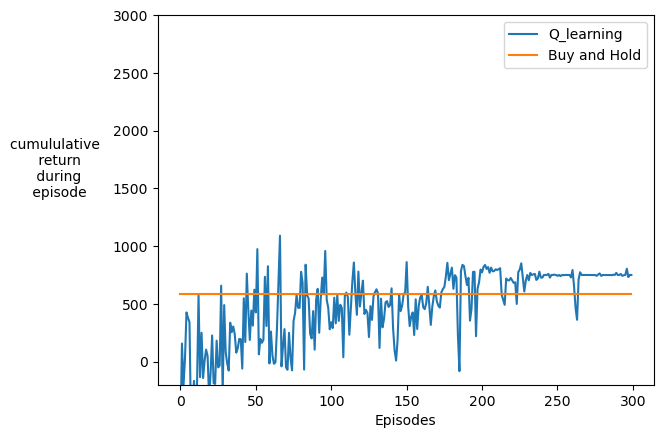

In [24]:
plt.plot(cumulative_returns, label= "Q_learning")
plt.plot(profits, label="Buy and Hold")
plt.xlabel("Episodes")
plt.ylabel("cumululative \n return\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-200,3000)
plt.legend()
plt.show()

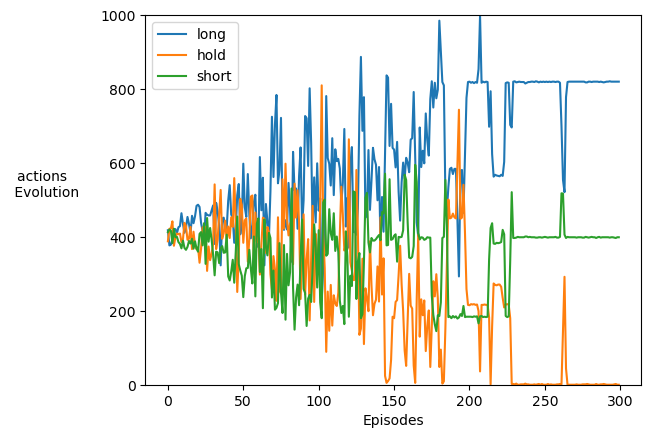

In [25]:
plt.plot(long_num, label= "long")
plt.plot(hold_num, label= "hold")
plt.plot(short_num, label= "short")
plt.xlabel("Episodes")
plt.ylabel("actions \n Evolution",rotation=0, labelpad=40)
plt.ylim(0,1000)
plt.legend()
plt.show()

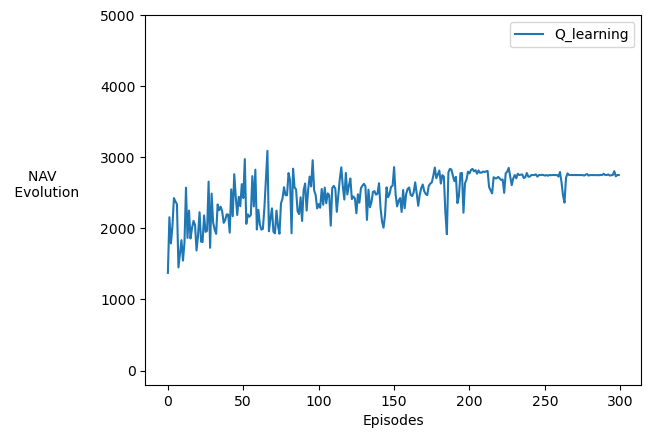

In [26]:
plt.plot(navs, label= "Q_learning")
plt.xlabel("Episodes")
plt.ylabel("NAV \n Evolution",rotation=0, labelpad=40)
plt.ylim(-200,5000)
plt.legend()
plt.show()

In [27]:
total_returns = [ ((navs[i]/2000)-1) for i in range(episode_num)]

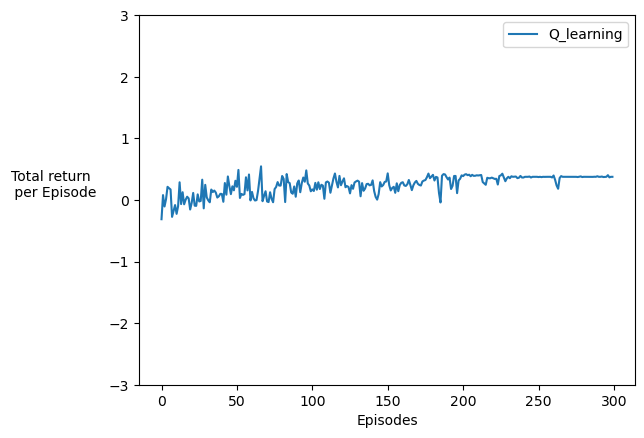

In [28]:
plt.plot(total_returns, label= "Q_learning")
plt.xlabel("Episodes")
plt.ylabel("Total return \n per Episode",rotation=0, labelpad=40)
plt.ylim(-3,3)
plt.legend()
plt.show()

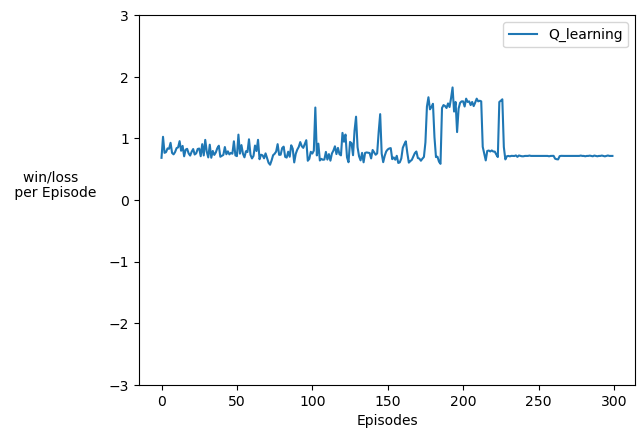

In [29]:
plt.plot(win_loss, label= "Q_learning")
plt.xlabel("Episodes")
plt.ylabel("win/loss \n per Episode",rotation=0, labelpad=40)
plt.ylim(-3,3)
plt.legend()
plt.show()

# testing

In [30]:
def getReward(index,last_position,TradingCost):
    # print(df.iloc[index+1,8])
    # print(last_position)
    return (test.iloc[index+1,3] * last_position) - TradingCost # (return amount * last postion ) - trading cost

In [31]:
episode_num= 1
agent.epsilon = 0
cumulative_returns = []
navs = [] # for nav evolution
profits = [] # for buy and hold
win_loss = [] # win/loss ratio
long_num = [] 
hold_num = [] 
short_num = [] 
for episode in range(episode_num):
    state = get_state(test.iloc[0,:])
    # print(state)
    last_position = 0 # first position is hold
    cumulative_return = 0 
    profit = 0
    termination = False
    index = 0
    nav = 2000 # equvalent to 1 dollar
    actions_num = [0,0,0] # short - hold - long
    win = 0
    loss = 0
    reward_of_current_trade = 0 # for win-loss measure
    while termination == False and index < test.shape[0]-150:
        action = agent.getAction(state)

        if action == 1 :
            actions_num[2] += 1
        elif action == 0:
            actions_num[1] += 1
        else :
            actions_num[0] += 1
            
        # print(action)
        TradingCost =0
        # print(index)
        # print(action)
        if action != 0:
            if last_position != action: # avoids getting long postion again instead just hold it
                last_position = action
                TradingCost = test.iloc[index,0] * 0.001  # 0.1 percent of the trade value.

                if reward_of_current_trade > 0:
                    win +=1
                else:
                    loss +=1
                reward_of_current_trade = 0 # when we trade again we set it to zero
                
        # using rsi for choosing action       
        # if action == 0 :
        #     if state[1] == "Oversold":
        #         last_position = 1
        #         TradingCost = df.iloc[index,0] * 0.001
        #     if state[1] == "Overbought":
        #         last_position = -1
        #         TradingCost = df.iloc[index,0] * 0.001

        # print(last_position)
        reward = getReward(index,last_position,TradingCost)
        reward_of_current_trade += reward
        nav += reward
        profit += test.iloc[index+1,3] 
        profits.append(profit)
        cumulative_return += reward
        cumulative_returns.append(cumulative_return)
        if nav <= 0 :
            termination = True
        next_state = get_state(test.iloc[index+1,:])
        agent.update(state,action,reward,next_state)
        state = next_state
        index +=1
    # if nav < 0 :
    #     print(index)   
    
    navs.append(nav)
    
    if loss != 0:
        win_loss.append(win/loss)
    long_num.append(actions_num[2])
    hold_num.append(actions_num[1])
    short_num.append(actions_num[0])
    # print(agent.epsilon)

In [32]:
agent.Q

-1         0          1
Return_binned RSI_binned Volume_binned                               
Down          Oversold   low            0.492420  1.235264   2.909041
                         medium        -2.111765  1.748031   3.478657
                         high           1.740862 -2.666652  -1.965194
              Neutral    low            1.530612  0.647215  -0.831898
                         medium         4.256035 -2.087744  -2.026139
                         high          -4.836651 -5.346409  -1.126672
              Overbought low            0.000000  0.000000   0.000000
                         medium        -0.104115 -1.048459   4.255154
                         high           4.388854  0.223921  -0.843584
Flat          Oversold   low            0.384029  0.215717   0.174591
                         medium         0.000000  0.000000   0.000000
                         high          -0.033240  0.733507   0.000000
              Neutral    low            0.118907  0.151210   0.784867
                         medium        -2.134059 -1.376356   1.531766
                         high          -0.900882 -1.642156   4.011500
              Overbought low            0.000000  0.000000   0.000000
                         medium         0.138590  0.107251   0.736142
                         high           3.190618  0.477969   0.389789
Up            Oversold   low            0.000000  0.000000   0.000000
                         medium        -5.516922  7.301610  14.841850
                         high          -1.039796  7.583832  16.282556
              Neutral    low           -1.952585  0.569123   3.362335
                         medium        -0.870097 -1.706095   4.530500
                         high          -3.232638 -2.908439   0.200633
              Overbought low           -6.371346  4.371370   9.144324
                         medium        -0.691838  1.484924   4.535871
                         high           1.416683 -2.995712  -3.465085

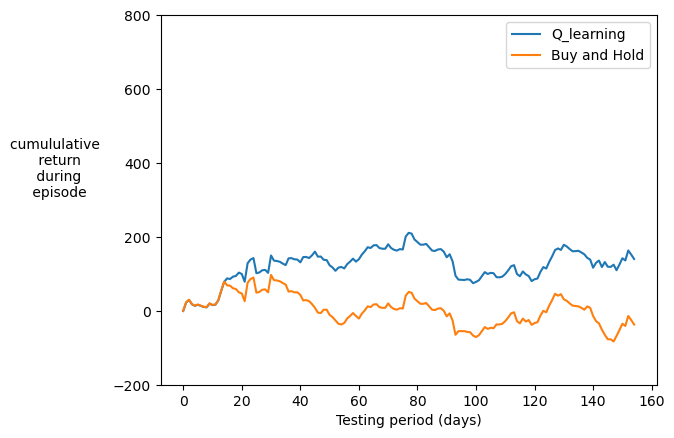

In [33]:
plt.plot(cumulative_returns, label= "Q_learning")
plt.plot(profits, label="Buy and Hold")
plt.xlabel("Testing period (days)")
plt.ylabel("cumululative \n return\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-200,800)
plt.legend()
plt.show()